# ニューラルネットワークの実装 2 （回帰）

本章では TensorFlow を使用して回帰の問題設定に対する実装方法を学んでいきます。基本的には分類と同様の手順で実装を行うことが可能です。  
できる方は本章を読み進める前にご自身で実装を行ってみて下さい。  

本章では少し発展的な TensorFlow の実装方法についても紹介していきます。

## 本章の構成

- データセットの準備
- モデルの定義
- 目的関数・最適化手法の選択
- モデルの学習
- 予測精度の評価

## データセットの準備

必要なモジュールのインポートとデータセットの読み込みを行います。  
今回使用するデータセットは scikit-learn に準備されているボストン市の家賃に関するデータセットを用います。  

目的変数に家賃 (Target)、入力変数に住宅に関する情報を持つデータセットで、家賃を予測する回帰の問題設定になります。  

データセットの詳細に関しては[こちら](https://scikit-learn.org/stable/datasets/index.html#boston-dataset)を参照して下さい。  

In [1]:
# 必要なモジュールの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
!pip show scikit-learn

2025-06-03 11:30:32.955714: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-03 11:30:32.956190: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 11:30:32.958227: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 11:30:32.963515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748917832.972414  989598 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748917832.97

Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: 
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIB

In [2]:
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()

In [3]:
colms_name = dataset.feature_names
x = dataset.data
t = dataset.target

In [4]:
# 読み込んだデータセットをデータフレーム形式に変換
df = pd.DataFrame(data=x, columns=colms_name)
df['Target'] = t
df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521


### データセットの確認

ニューラルネットワークを含む機械学習のアルゴリズムはどのようなデータセットを使用するかが非常に重要です。また、適切な前処理を加えることによって精度向上に繋がる場合は多くあります。本章では前処理の実装は行いませんがデータセットの中身を確認方法を再度確認しておきます。

In [5]:
# サンプル数（行数）、入力・目的変数の数（列数）の確認
df.shape

(20640, 9)

<Axes: xlabel='Target', ylabel='Count'>

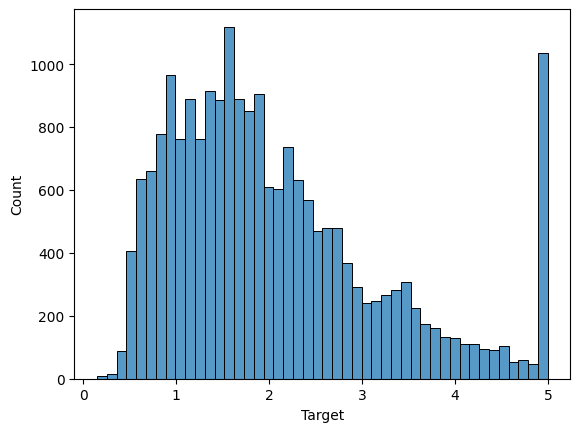

In [6]:
# 目的変数の分布の確認
sns.histplot(df['Target'])

分布を確認すると値が 50 以上のものが少しその周辺よりも多く、外れ値のようになっています。このようなケースでは、$3 \sigma$ 法などを用いて、外れ値除去を行い、問題設定を切り分けるアプローチが考えられます。  

続いて相関係数を確認しましょう。相関係数は `corr()` メソッドで取得可能です。また、取得した相関係数を Seaborn の heatmap() 関数を用いて可視化します。

<Axes: >

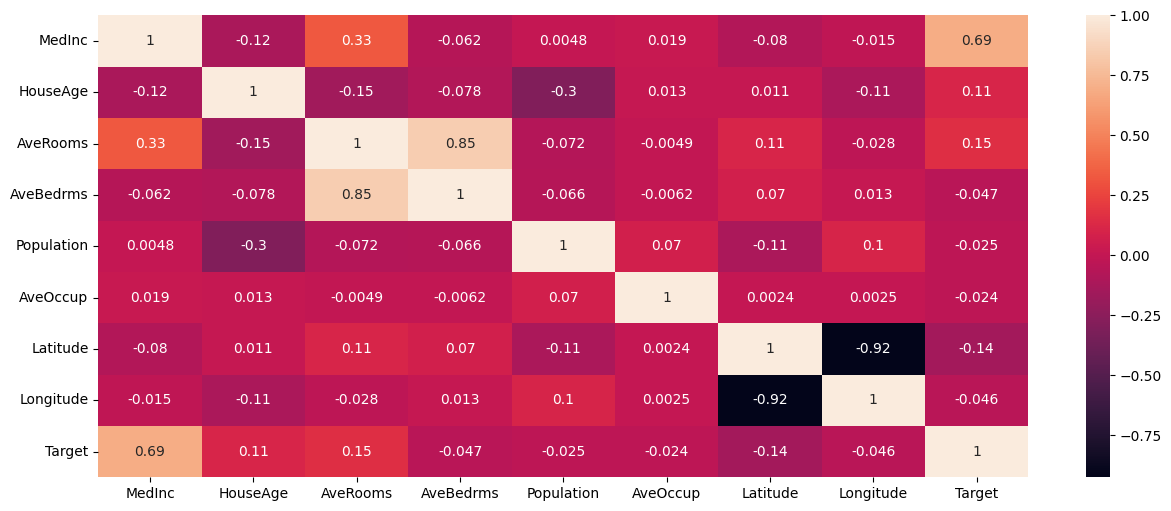

In [7]:
plt.figure(figsize=(15, 6))
sns.heatmap(df.corr(), annot=True)

入力変数同士で相関係数が高いものが存在する事は[多重共線性](https://ja.wikipedia.org/wiki/%E9%87%8D%E5%9B%9E%E5%B8%B0%E5%88%86%E6%9E%90)などを引き起こすなどの理由から好ましくありません。今回は特別相関係数の高い入力変数は存在しませんが、必要であれば相関係数の値から入力変数の選定を行います。  




### 入力変数と目的変数の切り分け

分類の問題設定と同様に入力変数と目的変数の切り分けを行います。  

In [8]:
# 入力変数（Target 列以外の列を取得）
x = df.drop('Target', axis=1)

# 目的変数（Target の列のみを取得）
t = df['Target']

In [9]:
x.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24


### TensorFlow で計算できるデータの形式に変換

分類ではラベルの最小値が 0 である必要がありましたが、今回の回帰の問題設定では特にその必要はありません。しかし、**データは NumPy の ndarray オブジェクトで定義されている必要があります。**  

`values` 属性から取得することができます。

In [10]:
type(x)

pandas.core.frame.DataFrame

In [11]:
x = x.values
t = t.values

In [12]:
type(x)

numpy.ndarray

入力値のデータ型は `numpy.float32`、回帰の問題では目標値のデータ型も `numpy.float32` である必要があります。

In [13]:
x.dtype

dtype('float64')

In [14]:
# それぞれのデータ型を変換
x = x.astype('float32')
t = t.astype('float32')

In [15]:
x.dtype, t.dtype

(dtype('float32'), dtype('float32'))

### 学習用データセットとテスト用データセットに分割

モデルの学習を行うためのデータセットと、予測精度を測るためのデータセットへの切り分けを行います。  

In [16]:
from sklearn.model_selection import train_test_split

# 学習用データセットとテスト用データセットの分割
x_train, x_test, t_train, t_test = train_test_split(x, t, train_size=0.7, random_state=0)

分割が完了した後は、それぞれのデータセットのサンプル数を確認し、正常に分割できていることを確認しましょう。

In [17]:
x_train.shape, x_train.dtype, x_test.shape, x_test.dtype

((14447, 8), dtype('float32'), (6193, 8), dtype('float32'))

In [18]:
t_train.shape, t_train.dtype, t_test.shape, t_test.dtype

((14447,), dtype('float32'), (6193,), dtype('float32'))

これで学習を行うためのデータセットの準備が整いました。

## モデルの定義

まずは前章のコードを参考にして、ご自身でモデルの定義を行って下さい。その後に資料の続きを確認していきましょう。

In [19]:
import os, random

# シードを固定するための関数の定義
def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed) # random関数のシードを固定
    np.random.seed(seed) # numpyのシードを固定
    tf.random.set_seed(seed) # tensorflowのシードを固定

前章の分類の問題設定に対し使用した下記のコードを今回の問題設定に合わして変更を加えましょう。

In [20]:
# このコードに変更を加える

from tensorflow.keras import models,layers
# シードの固定
reset_seed(0)

# モデルのインスタンス化
model = models.Sequential()

# モデルの構築
model.add(layers.Dense(10, activation='relu', input_shape=(30,)))
model.add(layers.Dense(2, activation='softmax'))

/home/kinoko1943/development/github/TKAdvanced/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-03 11:30:41.406056: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


前回と今回の異なる点は下記になります。  

- 使用するデータセットが異なる
- 分類ではなく、回帰の問題設定

変更したコードを確認します。

In [21]:
len(x_train[0])

8

In [22]:
# 変更後のコード
# シードの固定
reset_seed(0)

# モデルのインスタンス化
model = models.Sequential()

# モデルの構築
model.add(layers.Dense(10, activation='relu', input_shape=(8,)))
model.add(layers.Dense(1))

変更点は下記になります。  

- 入力層のノードの数
- 出力層のノードの数
- 出力層のソフトマックス関数の除去

今回のデータセットの入力変数の数は 13 であるため、その数に合わせて入力層の `input_shape` の引数を変更する必要がありました。また、出力層の `units` の引数も家賃の 1 つの数値を予測するため変更する必要があります。今回の問題設定は回帰で数値を予測するため、ソフトマックス関数を適用して、値を 0~1 の間に変換する必要がありません。  

### Functional API を用いてモデルの定義

これまでは Sequential API を用いて実装を行ってきましたが、少し発展的な **Functional API** を用いての実装方法を紹介します。本講座では基本的には Sequential API を用いて実装を行いますが、何か発展的な実装を行う際には Functional API が必要となります。ここで基礎的な実装方法を理解しましょう。  

#### Functional API の概要

Functional API では Sequectial API と異なり入力値、出力値、層、モデルなどの共有が可能となります。これにより fucntional API ではより柔軟にネットワークの構築を行うことが可能になります。  

例えば 3 層のニューラルネットワークを作成した際に 1 層目の出力を 2 層目を飛ばして、3 層目の入力として再度使用することなどが可能になります。  

また、[オートエンコーダ (autoencoder)](https://ja.wikipedia.org/wiki/%E3%82%AA%E3%83%BC%E3%83%88%E3%82%A8%E3%83%B3%E3%82%B3%E3%83%BC%E3%83%80) と呼ばれるアルゴリズムのような、エンコーダーとデコーダーの 2 つのモデルを持つような構造のモデルもモデル自体共有することにより構築が可能となります。  

![functional API でのモデル構築例](https://www.tensorflow.org/guide/keras/functional_files/output_ef7ac19c83be_0.png)

*出典 : [Google LLC](https://www.tensorflow.org/guide/keras/functional)*


#### Functional API の実装

記述方法に大きく違いはありませんが下記の点に注意する必要がある。  

- 入力値の形を定義する `Input` を記述する必要がある
- `layers.Dense(10, activation='relu')(inputs)` のように層に対応する入力値を記述する必要がある
- 層の計算を変数に格納する必要がある

実際に Functional API を用いて実装を行いましょう。

In [23]:
from tensorflow.keras import models, layers, Input

# シードの固定
reset_seed(0)

# モデルの構築
inputs = Input(shape=(8,)) # 入力値の形の定義
x = layers.Dense(3, activation='relu')(inputs)
outputs = layers.Dense(1)(x)

model = models.Model(inputs=inputs, outputs=outputs, name='linear_model')

今回は Functional API を用いて比較的シンプルなモデルの構築を行いました。複雑なモデルの構築方法などに関してはこちらの[公式ドキュメント](https://www.tensorflow.org/guide/keras/functional)を参照して下さい。  

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## 目的関数・最適化手法の選択

### 最適化手法の選択

モデルの定義以外は sequential API と同様の記述方法になります。
`tf.keras.optimizers` モジュールを使用して、最適化手法の選択を行います。  
今回は [Adam](https://ja.wikipedia.org/wiki/%E7%A2%BA%E7%8E%87%E7%9A%84%E5%8B%BE%E9%85%8D%E9%99%8D%E4%B8%8B%E6%B3%95#Adam) と呼ばれる最適化手法を使用します。  

最適化手法も一種のハイパーパラメータと呼ぶことができます。最適化手法を変更することによって、パラメータの更新の方法が異なります。Adam は比較的効率よく学習を行うことができると経験的に言われています。  
うまく学習が進まない場合は最適化手法や学習係数を変更してみて、学習結果を確認してみて下さい。  


### 目的関数の選択

今回の問題設定は回帰であるため、目的関数には**平均二乗誤差 (mean squared error ; mse)** を用います。  
評価には**二乗平均平方根誤差 (root mean squared error ; rmse)**を使用します。二乗平均平方根誤差は平均二乗誤差に $\sqrt{}$ を適用し、スケールを戻したものになります。  

In [25]:
# optimizer　の設定
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rmse = tf.keras.metrics.RootMeanSquaredError()

# モデルのコンパイル
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[rmse])

## モデルの学習

前章でもお伝えましたが、モデルの学習時にはミニバッチ学習を行う際のバッチサイズとエポック数を定義する必要があります。

In [26]:
# バッチサイズとエポック数の定義
batch_size = 32
epochs = 10

# 学習の実行
history = model.fit(x_train, t_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, t_test))

Epoch 1/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - loss: 5.6198 - root_mean_squared_error: 2.3641 - val_loss: 4.7312 - val_root_mean_squared_error: 2.1751
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 3.8038 - root_mean_squared_error: 1.9498 - val_loss: 3.3073 - val_root_mean_squared_error: 1.8186
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 2.7788 - root_mean_squared_error: 1.6665 - val_loss: 2.5295 - val_root_mean_squared_error: 1.5904
Epoch 4/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 2.1161 - root_mean_squared_error: 1.4543 - val_loss: 2.0459 - val_root_mean_squared_error: 1.4304
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 1.7164 - root_mean_squared_error: 1.3099 - val_loss: 1.7716 - val_root_mean_squared_error: 1.3310
Epoch 6/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 1.4996 - root_mean_squared_error: 1.2244 - val_loss: 1.6334 - val_root_mean_squared_error: 1.2781
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 

## 予測精度の評価

学習結果を取得し、モデルの予測精度を確認します。

In [27]:
results = pd.DataFrame(history.history)
results.tail(3)

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
7,1.342567,1.158692,1.549820,1.244918
8,1.333395,1.154727,1.541381,1.241524
9,1.331272,1.153808,1.538140,1.240218


Text(0.5, 0, 'epochs')

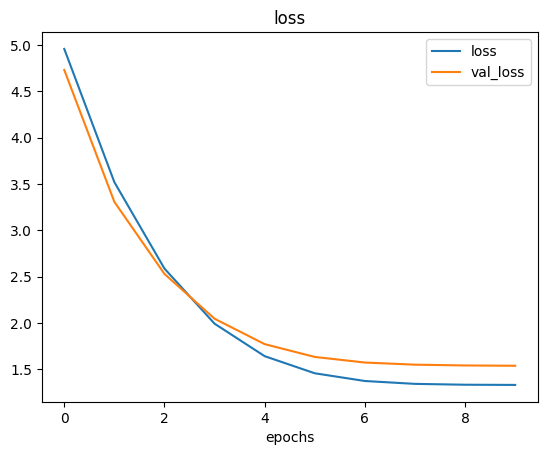

In [28]:
# 損失を可視化
results[['loss', 'val_loss']].plot(title='loss')
plt.xlabel('epochs')

テスト用データセットに対する二乗平均平方根誤差　(以後 RMSE) の値が約 1.236 となっている事がわかります。  

## 練習問題 本章のまとめ

本章で学んだ内容を復習しましょう。下記の内容を次のセルに記述し、実行結果を確認してください。（必要に応じてセルの追加を行ってください。）

今回のデータセット（ボストン市の家賃に関するデータ）を用いて、家賃を予測するモデルの構築を再度行って下さい。また、ハイパーパラメータの調整を行い、モデルの予測精度向上を行いましょう。目標となる RMSE は 1 以下です。（目的変数・入力変数、データセットの切り分けなどの情報は前述の内容を確認して下さい。）  

実装は下記の流れを参照して下さい。  

- データセットの準備
- モデルの定義
- 目的関数・最適化手法の選択
- モデルの学習
- 予測精度の評価
- ハイパーパラメータの調整  

*精度向上のヒント*

- 層・ノードの数の変更
- バッチノーマリゼーションの層の追加
- エポック数の調整
- 学習係数の調整
- 最適化手法の変更
- データセットに対する前処理（入力変数の選択など）

In [29]:
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
colms_name = dataset.feature_names
x = dataset.data
t = dataset.target

In [30]:
# 読み込んだデータセットをデータフレーム形式に変換
df = pd.DataFrame(data=x, columns=colms_name)
df['Target'] = t
df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521


#### データセットの準備

In [31]:
# それぞれのデータ型を変換
x = x.astype('float32')
t = t.astype('float32')

In [32]:
x.dtype, t.dtype

(dtype('float32'), dtype('float32'))

**学習用データセットとテスト用データセットに分割**


In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, t_train, t_test = train_test_split(x, t, train_size=0.7, random_state=0)

In [34]:
x_train.shape, x_test.shape

((14447, 8), (6193, 8))

#### モデルの定義

In [35]:
import os, random

# シードを固定するための関数の定義
def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed) # random関数のシードを固定
    np.random.seed(seed) # numpyのシードを固定
    tf.random.set_seed(seed) # tensorflowのシードを固定

In [36]:
from tensorflow.keras import models, layers, Input

# シードの固定
reset_seed(0)

# モデルの構築
inputs = Input(shape=(8,)) # 入力値の形の定義
x = layers.Dense(3, activation='relu')(inputs)
outputs = layers.Dense(1)(x)

model = models.Model(inputs=inputs, outputs=outputs, name='linear_model')

#### 目的関数・最適化手法の選択

In [37]:
# optimizer　の設定
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rmse = tf.keras.metrics.RootMeanSquaredError()

# モデルのコンパイル
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[rmse])

#### モデルの学習

In [38]:
# バッチサイズとエポック数の定義
batch_size = 32
epochs = 10

# 学習の実行
history = model.fit(x_train, t_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, t_test))

Epoch 1/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step - loss: 5.6198 - root_mean_squared_error: 2.3641 - val_loss: 4.7312 - val_root_mean_squared_error: 2.1751
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 3.8038 - root_mean_squared_error: 1.9498 - val_loss: 3.3073 - val_root_mean_squared_error: 1.8186
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 2.7788 - root_mean_squared_error: 1.6665 - val_loss: 2.5295 - val_root_mean_squared_error: 1.5904
Epoch 4/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 2.1161 - root_mean_squared_error: 1.4543 - val_loss: 2.0459 - val_root_mean_squared_error: 1.4304
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 1.7164 - root_mean_squared_error: 1.3099 - val_loss: 1.7716 - val_root_mean_squared_error: 1.3310
Epoch 6/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 1.4996 - root_mean_squared_error: 1.2244 - val_loss: 1.6334 - val_root_mean_squared_error: 1.2781
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 

#### 予測精度の評価

Text(0.5, 0, 'epochs')

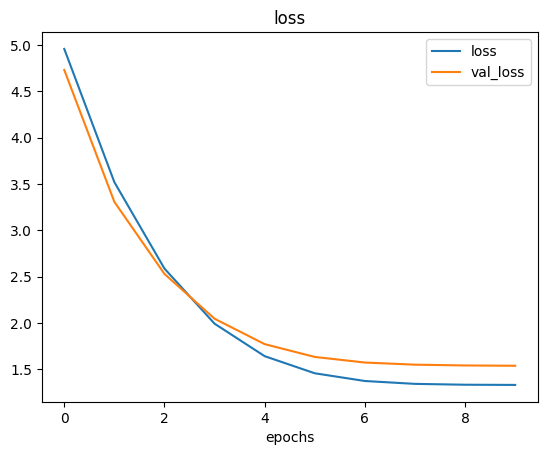

In [39]:
results = pd.DataFrame(history.history)
results.tail(3)

# 損失を可視化
results[['loss', 'val_loss']].plot(title='loss')
plt.xlabel('epochs')

#### ハイパーパラメータの調整

Epoch 1/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 345403.7188 - root_mean_squared_error: 582.2006 - val_loss: 55767.4844 - val_root_mean_squared_error: 236.1514
Epoch 2/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 40085.1250 - root_mean_squared_error: 199.5751 - val_loss: 12708.2617 - val_root_mean_squared_error: 112.7309
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 10122.1895 - root_mean_squared_error: 100.4652 - val_loss: 4321.0137 - val_root_mean_squared_error: 65.7344
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 3656.7930 - root_mean_squared_error: 60.4229 - val_loss: 1819.4991 - val_root_mean_squared_error: 42.6556
Epoch 5/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 1603.7219 - root_mean_squared_error: 40.0230 - val_loss: 868.9344 - val_root_mean_squared_error: 29.4777
Epoch 6/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 789.7336 - root_mean_squared_error: 28.0861 - val_loss: 449.3968 - val_root_mean_squared

Text(0.5, 0, 'epochs')

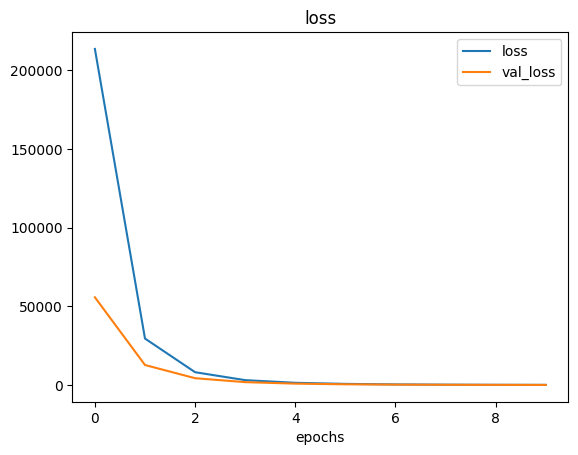

In [40]:


from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
colms_name = dataset.feature_names
x = dataset.data
t = dataset.target

# 読み込んだデータセットをデータフレーム形式に変換
df = pd.DataFrame(data=x, columns=colms_name)
df['Target'] = t
df.head(3)

# それぞれのデータ型を変換
x = x.astype('float32')
t = t.astype('float32')

x.dtype, t.dtype


from sklearn.model_selection import train_test_split
x_train, x_test, t_train, t_test = train_test_split(x, t, train_size=0.7, random_state=0)

import os, random

# シードを固定するための関数の定義
def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed) # random関数のシードを固定
    np.random.seed(seed) # numpyのシードを固定
    tf.random.set_seed(seed) # tensorflowのシードを固定

from tensorflow.keras import models, layers, Input

# シードの固定
reset_seed(0)

# モデルの構築
inputs = Input(shape=(8,)) # 入力値の形の定義
x = layers.Dense(4, activation='relu')(inputs)
outputs = layers.Dense(1)(x)

model = models.Model(inputs=inputs, outputs=outputs, name='linear_model')

# optimizer　の設定
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
rmse = tf.keras.metrics.RootMeanSquaredError()

# モデルのコンパイル
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[rmse])



# バッチサイズとエポック数の定義
batch_size = 64
epochs = 10

# 学習の実行
history = model.fit(x_train, t_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, t_test))
results = pd.DataFrame(history.history)
results.tail(3)

# 損失を可視化
results[['loss', 'val_loss']].plot(title='loss')
plt.xlabel('epochs')


---
© 株式会社キカガク及び国立大学法人 豊橋技術科学大学